Confidence bike: 0.99434494972229 | Confidence no bike: 0.0
Confidence bike: 0.9911333918571472 | Confidence no bike: 0.0
Confidence bike: 0.9900988936424255 | Confidence no bike: 0.0
Confidence bike: 0.8500498533248901 | Confidence no bike: 0.0
Confidence bike: 0.9955655932426453 | Confidence no bike: 0.0
Confidence bike: 0.7562081813812256 | Confidence no bike: 0.0
Confidence bike: 0.8907012939453125 | Confidence no bike: 0.0
Confidence bike: 0.9692027568817139 | Confidence no bike: 0.0
Confidence bike: 0.9943331480026245 | Confidence no bike: 0.0
Confidence bike: 0.9623285531997681 | Confidence no bike: 0.0

Detection error: 0.8884426948361916


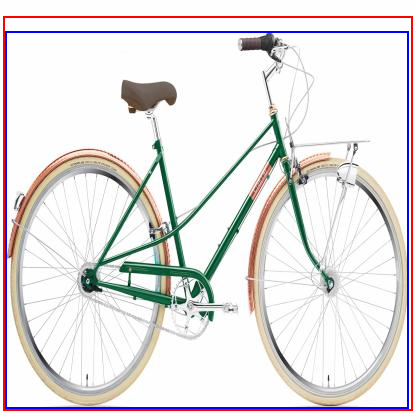

Intersection over Union: 0.9419435010805804


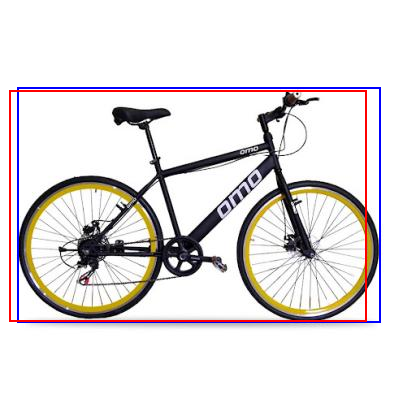

Intersection over Union: 0.9265273008755216


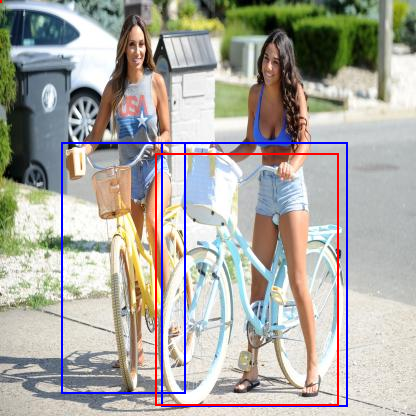

Intersection over Union: 0.054452342267820156


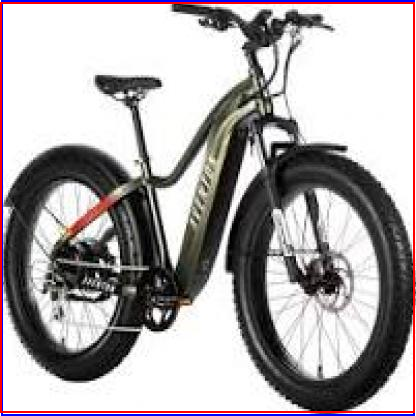

Intersection over Union: 0.9825631373297036


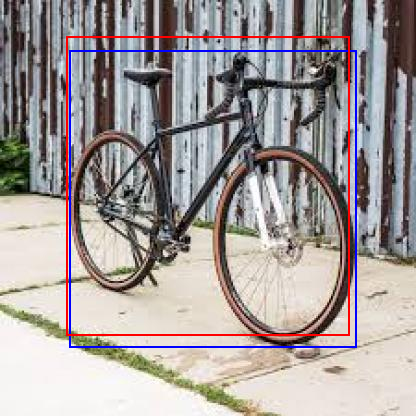

Intersection over Union: 0.8815318366556997


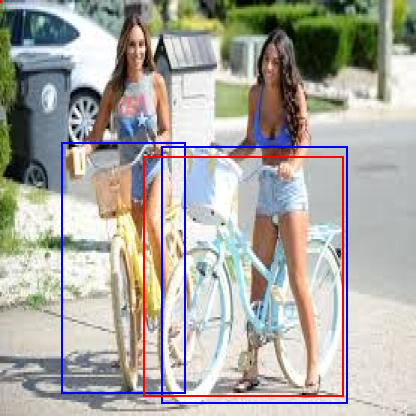

Intersection over Union: 0.07507232630289089


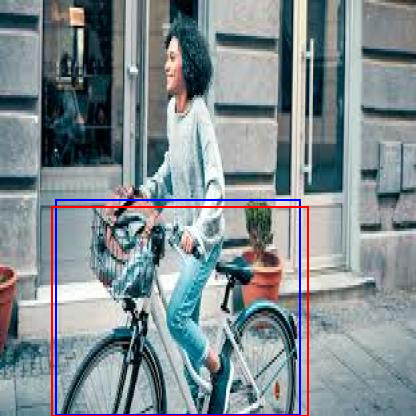

Intersection over Union: 0.9235362197229486


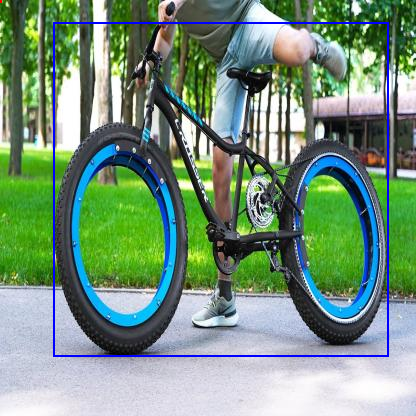

Intersection over Union: 0.0


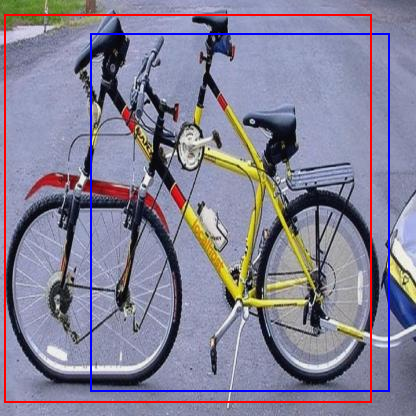

Intersection over Union: 0.6760647527748127


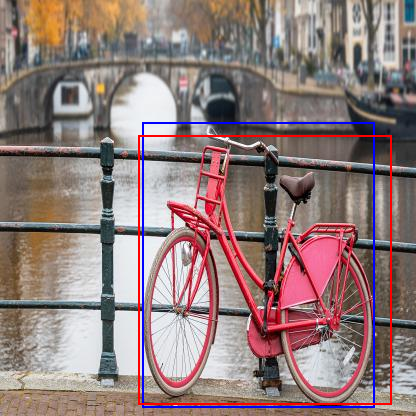

Intersection over Union: 0.8702413230847074

Accuracy: 0.7391304347826086 | Precision: 0.7 | Recall: 0.7


In [41]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from azure.ai.vision.imageanalysis.models import VisualFeatures
from msrest.authentication import CognitiveServicesCredentials

import os

from PIL import Image, ImageDraw

bike_classifiers = ["bike", "bicycle", "road bicycle", "hybrid bicycle", "cycle"]

'''
    Computes the confidence levels of images containing bikes and
    images which don't contain bikes, with respect to bikes.
    
    Uses those confidence levels for computing the error.
    
    :param cvc: The Azure Vision model used for object detection.
    :ptype cvc: ComputerVisionClient
'''
def compute_classification_error(cvc: ComputerVisionClient):
    # Extracting the confidence level of the algorithm for recognizing bikes.
    confidence_bikes = []
    confidence_no_bikes = []
    
    # Training/Test - 5 images with bikes, 5 images without bikes.
    
    # TRAINING
    
    # Processing the bike images.
    for i in range(1, 6):
        path = "./images/bike" + str(i) + ".jpg"
        
        with open(path, "rb") as img:
            result = cvc.analyze_image_in_stream(
                image=img,
                visual_features=[VisualFeatureTypes.tags]
            )
            
            bike_tags = []
            for tag in result.tags:
                if tag.name in bike_classifiers:
                    bike_tags.append(tag)
            
            max_confidence = max(tag.confidence for tag in bike_tags)
            confidence_bikes.append(max_confidence)
        
    # Processing the traffic images (images containing no bikes -> a motorcycle isn't a bike)
    for i in range(1, 6):
        path = "./images/traffic" + str(i) + ".jpg"
        
        with open(path, "rb") as img:
            result = cvc.analyze_image_in_stream(
                image=img,
                visual_features=[VisualFeatureTypes.tags]
            )
            
            bike_tags = []
            for tag in result.tags:
                if tag.name in bike_classifiers:
                    bike_tags.append(tag)
            
            if bike_tags == []:
                confidence_no_bikes.append(0.0)
            else:
                max_confidence = max(tag.confidence for tag in bike_tags)
                confidence_no_bikes.append(max_confidence)
            
    # TEST
    
    for i in range(6, 11):
        path = "./images/bike" + str(i) + ".jpg"
        
        with open(path, "rb") as img:
            result = cvc.analyze_image_in_stream(
                image=img,
                visual_features=[VisualFeatureTypes.tags]
            )
            
            bike_tags = []
            for tag in result.tags:
                if tag.name in bike_classifiers:
                    bike_tags.append(tag)
            
            max_confidence = max(tag.confidence for tag in bike_tags)
            confidence_bikes.append(max_confidence)
        
    for i in range(6, 11):
        path = "./images/traffic" + str(i) + ".jpg"
        
        with open(path, "rb") as img:
            result = cvc.analyze_image_in_stream(
                image=img,
                visual_features=[VisualFeatureTypes.tags]
            )
            
            bike_tags = []
            for tag in result.tags:
                if tag.name in bike_classifiers:
                    bike_tags.append(tag)
            
            if bike_tags == []:
                confidence_no_bikes.append(0.0)
            else:
                max_confidence = max(tag.confidence for tag in bike_tags)
                confidence_no_bikes.append(max_confidence)
            
    # Computing the total error.
    err = 0
    for val in zip(confidence_bikes, confidence_no_bikes):
        print(f"Confidence bike: {val[0]} | Confidence no bike: {val[1]}")
        err = err + (val[0] - val[1]) ** 2
    err /= 10
    
    print(f"\nDetection error: {err}")

'''
    Computes the intersection over union between two rectangles.
    The intersection over union is a measure of the similarity between two lists of rectangles.
    The higher the intersection over union for two lists of rectangles is, the more similar the lists are.
    
    :param rectangles_truth: the first list of rectangles
    :param rectangle_hypothesis: the second list of rectangles
    
    :return: the intersection over union between the two lists of rectangles
    :rtype: float
'''
def intersection_over_union(rectangles_truth: list, rectangles_hypothesis: list):
    iou = 0.0
    
    for i in range(len(rectangles_truth)):
        x  =  max(rectangles_truth[i][0], rectangles_hypothesis[i][0])
        y  =  max(rectangles_truth[i][1], rectangles_hypothesis[i][1])
        xt =  min(rectangles_truth[i][2], rectangles_hypothesis[i][2])
        yt =  min(rectangles_truth[i][3], rectangles_hypothesis[i][3])
        
        interArea = max(0, xt - x + 1) * max(0, yt - y + 1)
        rectangle_truthArea = (rectangles_truth[i][2] - rectangles_truth[i][0] + 1) * (rectangles_truth[i][3] - rectangles_truth[i][1] + 1)
        rectangle_hypothesisArea = (rectangles_hypothesis[i][2] - rectangles_hypothesis[i][0] + 1) * (rectangles_hypothesis[i][3] - rectangles_hypothesis[i][1] + 1)
        
        iou += interArea / float(rectangle_hypothesisArea + rectangle_truthArea - interArea)
        
    return iou / len(rectangles_truth)

'''
    Determines the bounding boxes determined by the model and
    computes the error of the recognition using
    Inserection over Union and Average Precision.
    
    :param cvc: The Azure Vision model used for object detection.
    :ptype cvc: ComputerVisionClient
    
    :param bound_boxes: The ground truth representing the bounding boxes.
    :ptype bound_boxes: list
'''      
def process_bike_images(cvc: ComputerVisionClient, bound_boxes: list):
    # Drawing the bounding boxes determined manually and those determined by the model.
    # If the model can't determine a bounding box for the bike, the drawing will have only the bounding box determined manually.
    
    tp, fp, tn, fn = 0, 0, 0, 0
    hypothesis_bounding_boxes = []
    threshold = 0.6
    
    # Processing the bike images to determine the number of correct detections
    # and number of wrong classification as negative.
    for i in range(1, 11):
        path = "./images/bike" + str(i) + ".jpg"
        
        with open(path, "rb") as img_bytes:
            result = cvc.analyze_image_in_stream(
                image=img_bytes,
                visual_features=[VisualFeatureTypes.objects]
            )
            # List containing the bounding boxes of determined by the model.
            hypothesis_bounding_box = []
            
            # Retrieving the bounding boxes determined by the model.
            for object in result.objects:
                if object.object_property in bike_classifiers:
                    x = object.rectangle.x
                    y = object.rectangle.y
                    xw = x + object.rectangle.w
                    yh = y + object.rectangle.h
                    
                    hypothesis_bounding_box.append([x, y, xw, yh])
            
            if len(bound_boxes[i - 1]) != len(hypothesis_bounding_box):
                fn += 1
            
            if len(bound_boxes[i - 1]) > len(hypothesis_bounding_box) :
                l = len(bound_boxes[i - 1]) - len(hypothesis_bounding_box)
                for j in range(l):
                    hypothesis_bounding_box.append([0.0, 0.0, 0.0, 0.0])
            elif len(bound_boxes[i - 1]) < len(hypothesis_bounding_box):
                l = len(hypothesis_bounding_box) - len(bound_boxes[i - 1])
                for j in range(l):
                    bound_boxes[i-1].append([0.0, 0.0, 0.0, 0.0])
                
            hypothesis_bounding_boxes.append(hypothesis_bounding_box)
            iou = intersection_over_union(bound_boxes[i - 1], hypothesis_bounding_box)
            
            if iou >= threshold:
                tp += 1
            elif iou < threshold:
                fp += 1
                
    # Processing the images that do not contain bikes.
    for i in range(1, 11):
        path = "./images/traffic" + str(i) + ".jpg"
        
        with open(path, "rb") as img_bytes:
            result = cvc.analyze_image_in_stream(
                image=img_bytes,
                visual_features=[VisualFeatureTypes.objects]
            )
                
            # List containing the bounding boxes of determined by the model.
            hypothesis_bounding_box = []
            
            # Retrieving the bounding boxes determined by the model.
            for object in result.objects:
                if object.object_property in bike_classifiers:
                    x = object.rectangle.x
                    y = object.rectangle.y
                    xw = x + object.rectangle.w
                    yh = y + object.rectangle.h
                    
                    hypothesis_bounding_box.append([x, y, xw, yh])
                    
            if len(hypothesis_bounding_box) > 0:
                fp += 1
            else:
                tn += 1
                
    # Drawing the bounding boxes and determining the precision.
    for i in range(1, 11):
        path = "./images/bike" + str(i) + ".jpg"
        
        with open(path, "rb") as img_bytes:
            result = cvc.analyze_image_in_stream(
                image=img_bytes,
                visual_features=[VisualFeatureTypes.objects]
            )
            
            with Image.open(img_bytes, 'r') as img:
                draw = ImageDraw.Draw(img)
                
                for j in range(len(bound_boxes[i - 1])):
                    draw.rectangle(bound_boxes[i - 1][j], outline="blue", width=2)
                for j in range(len(hypothesis_bounding_boxes[i - 1])):
                    draw.rectangle(hypothesis_bounding_boxes[i - 1][j], outline="red", width=2)
                    
                display(img)
                iou = intersection_over_union(bound_boxes[i - 1], hypothesis_bounding_boxes[i - 1])
                
                print(f"Intersection over Union: {iou}")
                
    acc = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    print(f"\nAccuracy: {acc} | Precision: {precision} | Recall: {recall}")
'''
    Authenticates the Computer Vision client using the key and endpoint from the environment variables.
    
    :return: the Computer Vision client
    :rtype: ComputerVisionClient

'''
def authenticate() -> ComputerVisionClient:
    key = os.environ["VISUAL_KEY"]
    endpoint = os.environ["VISUAL_ENDPOINT"]
    
    return ComputerVisionClient(endpoint=endpoint, credentials=CognitiveServicesCredentials(key))

def enhance_bike3(path_bike3: str):
    # img = Image.open(path_bike3, 'r')
    
    # enhancer = ImageEnhance.Brightness(img)
    # img = enhancer.enhance(0.5)
    
    # enhancer = ImageEnhance.Contrast(img)
    # img = enhancer.enhance(0.5)
    
    # img = ImageOps.equalize(img)
    #img = img.filter(ImageFilter.SHARPEN)
    # img = img.filter(ImageFilter.EDGE_ENHANCE_MORE)
    
    # img.save("images/enhanced_bike3.jpg")
    pass

def detect_bike3(path_bike3: str, cvc: ComputerVisionClient):
    with open(path_bike3, 'rb') as img_bytes:
        result = cvc.analyze_image_in_stream(
                image=img_bytes,
                visual_features=[VisualFeatureTypes.objects]
            )
        
        hypothesis_bounding_box = []
        
        for object in result.objects:
                if object.object_property in bike_classifiers:
                    x = object.rectangle.x
                    y = object.rectangle.y
                    xw = x + object.rectangle.w
                    yh = y + object.rectangle.h
                    
                    hypothesis_bounding_box.append([x, y, xw, yh])
        
        with Image.open(img_bytes, 'r') as img:
            draw = ImageDraw.Draw(img)
            
            for i in range(len(hypothesis_bounding_box)):
                draw.rectangle(hypothesis_bounding_box[i], outline='blue', width=2)
            
            display(img)
            

def main():
    cvc = authenticate()
    
    bounding_boxes_ground_truth = [
        [[5.70, 31.50, 408.80, 408.00]],
        [[17.10, 87.50, 380.00, 322.10]],
        [   [61.80, 142.85, 185.70, 393.66],
            [161.04, 142.50, 347.10, 406.9]
        ],
        [[1.90, 0.40, 414.50, 415.30]],
        [[69.70, 50.00, 356.20, 347.80]],
        [
            [61.80, 142.85, 185.70, 393.66],
            [161.04, 146.30, 347.40, 403.89]
        ],
        [[55.80, 199.40, 300.40, 415.80]],
        [[53.40, 22.75, 388.40, 356.50]],
        [[90.19, 33.74, 389.12, 391.77]],
        [[142.10, 122.00, 374.70, 407.68]]
    ]
    
    compute_classification_error(cvc)
    process_bike_images(cvc, bounding_boxes_ground_truth)
    
    # bike3 = "images/bike3.jpg"
    # enhance_bike3(bike3)
    # detect_bike3("images/enhanced_bike3.jpg", cvc)
    
main()